In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data/ISIC2018/train/'
test_dir = 'data/ISIC2018/test/'
augmented_test_dir = 'data/ISIC2018/test-augmented/'

extracted_features_dir = "extracted_features/"
model_name = "VGG19_2018"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(augmented_test_dir):
    print (root, len(files))

data/ISIC2018/train/ 0
data/ISIC2018/train/melanoma 16760
data/ISIC2018/train/non-melanoma 17696
******************************
data/ISIC2018/test/ 0
data/ISIC2018/test/melanoma 239
data/ISIC2018/test/non-melanoma 1836
******************************
data/ISIC2018/test-augmented/ 0
data/ISIC2018/test-augmented/melanoma 7441
data/ISIC2018/test-augmented/non-melanoma 9242


In [5]:
output_classes = 2
batch_size = 16
img_height, img_width = 512, 512
input_shape = (img_height, img_width, 3)
epochs = 50

top_model_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_weights.h5')

nb_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
nb_test_samples = sum([len(files) for r, d, files in os.walk(test_dir)])
nb_augmented_test_samples = sum([len(files) for r, d, files in os.walk(augmented_test_dir)])

print("train samples:", nb_train_samples)
print("test samples:", nb_test_samples)
print("test augmented samples:", nb_augmented_test_samples)

train samples: 34456
test samples: 2075
test augmented samples: 16683


In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

Found 25842 images belonging to 2 classes.
Found 8614 images belonging to 2 classes.


In [7]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)

print("\n num_classes:", num_classes)

nb_train_samples: 25842
nb_validation_samples: 8614

predict_size_train: 1616
predict_size_validation: 539

 num_classes: 2


In [8]:
bottleneck_model = applications.VGG19(include_top=False, weights='imagenet')
# print(bottleneck_model.summary())

In [9]:
bottleneck_features_train = bottleneck_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [10]:
bottleneck_features_validation = bottleneck_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [9]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

augmented_test_generator = test_datagen.flow_from_directory(
    augmented_test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 2075 images belonging to 2 classes.
Found 16683 images belonging to 2 classes.


In [10]:
nb_test_samples = len(test_generator.filenames)
nb_augmented_test_samples = len(augmented_test_generator.filenames)

predict_size_test = int(math.ceil(nb_test_samples / batch_size))
predict_size_aug_test = int(math.ceil(nb_augmented_test_samples / batch_size))

print("nb_test_samples:", nb_test_samples)
print("nb_aug_test_samples:", nb_augmented_test_samples)
print("predict_size_test:", predict_size_test)
print("predict_size_test_aug:", predict_size_aug_test)

nb_test_samples: 2075
nb_aug_test_samples: 16683
predict_size_test: 130
predict_size_test_aug: 1043


In [11]:
bottleneck_features_test = bottleneck_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [12]:
bottleneck_features_aug_test = bottleneck_model.predict_generator(augmented_test_generator, predict_size_aug_test)
np.save(extracted_features_dir+'bottleneck_features_test_aug_'+model_name+'.npy', bottleneck_features_aug_test)

In [11]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

In [12]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 25842 samples, validate on 8614 samples
Epoch 1/50
 - 47s - loss: 0.5945 - acc: 0.6773 - val_loss: 0.5090 - val_acc: 0.7645
Epoch 2/50
 - 43s - loss: 0.5493 - acc: 0.7118 - val_loss: 0.4664 - val_acc: 0.7769
Epoch 3/50
 - 43s - loss: 0.5285 - acc: 0.7236 - val_loss: 0.4507 - val_acc: 0.7857
Epoch 4/50
 - 43s - loss: 0.5175 - acc: 0.7343 - val_loss: 0.4531 - val_acc: 0.7856
Epoch 5/50
 - 43s - loss: 0.5043 - acc: 0.7410 - val_loss: 0.4334 - val_acc: 0.7982
Epoch 6/50
 - 43s - loss: 0.4944 - acc: 0.7477 - val_loss: 0.4297 - val_acc: 0.7995
Epoch 7/50
 - 43s - loss: 0.4861 - acc: 0.7554 - val_loss: 0.4420 - val_acc: 0.7872
Epoch 8/50
 - 42s - loss: 0.4759 - acc: 0.7647 - val_loss: 0.4414 - val_acc: 0.7857
Epoch 9/50
 - 42s - loss: 0.4678 - acc: 0.7690 - val_loss: 0.4127 - val_acc: 0.8110
Epoch 10/50
 - 42s - loss: 0.4601 - acc: 0.7729 - val_loss: 0.4079 - val_acc: 0.8045
Epoch 11/50
 - 43s - loss: 0.4544 - acc: 0.7796 - val_loss: 0.4010 - val_acc: 0.8091
Epoch 12/50
 - 42s - loss

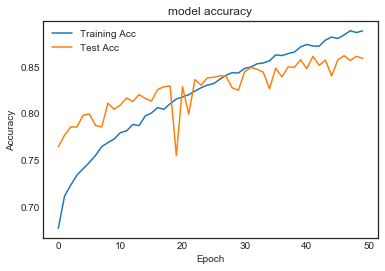

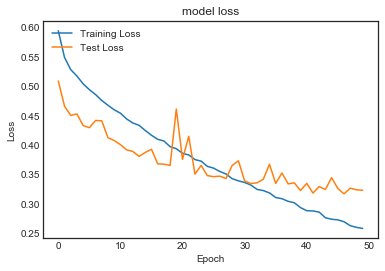

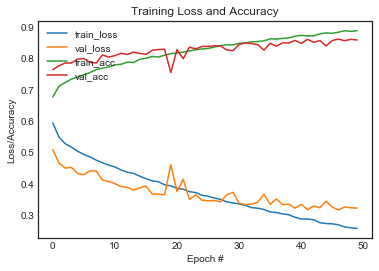

In [13]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [14]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

8614/8614 [==============================] - 4s 517us/step
Validation Accuracy: 85.8834%
Validation Loss: 0.3232800035956068


___
# Test without augmentation

In [15]:
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')
test_data_aug = np.load(extracted_features_dir+'bottleneck_features_test_aug_'+model_name+'.npy')

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

test_labels_aug = augmented_test_generator.classes
test_labels_aug = to_categorical(test_labels_aug, num_classes=num_classes)

In [16]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.7850602409638554


Confusion Matrix
[[ 222   17]
 [ 429 1407]]


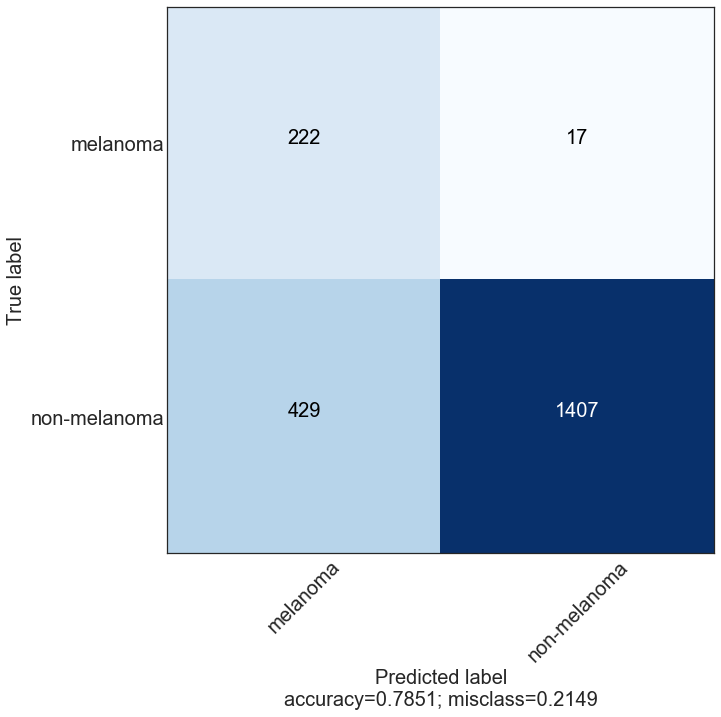

In [17]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[ 222   17]
 [ 429 1407]]
              precision    recall  f1-score   support

    melanoma       0.34      0.93      0.50       239
non-melanoma       0.99      0.77      0.86      1836

 avg / total       0.91      0.79      0.82      2075



In [19]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  78.50602409638554
Sensitivity :  34.10138248847927
Specificity :  98.8061797752809


In [20]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.6645378113188007


In [21]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

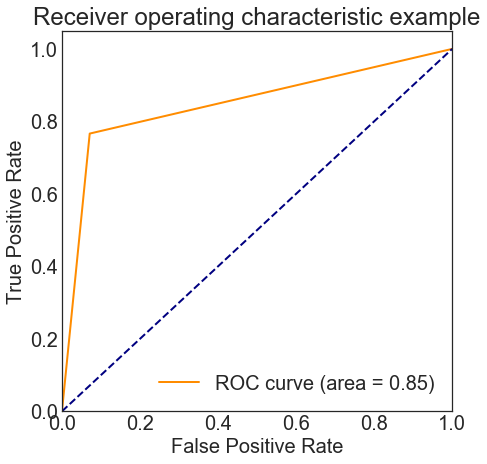

In [22]:
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [23]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

2075/2075 [==============================] - 1s 482us/step


In [24]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [25]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

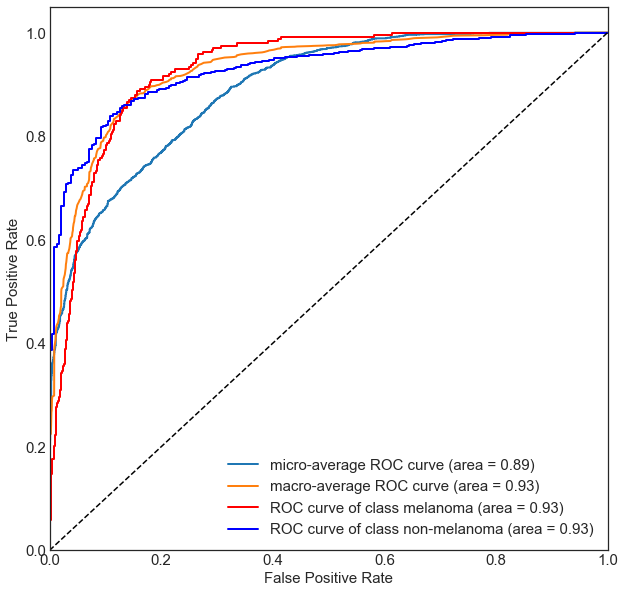

In [26]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [27]:
tn, fp, fn, tp = cm.ravel()

In [28]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn) 

Accuracy: 0.7850602409638554
Precision: 0.988061797752809
Recall: 0.7663398692810458
tp: 1407
fp: 17
tn: 222
fn: 429


In [29]:
# y_pred = np.argmax(y_pred,axis = 1) 

print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8631901840490798


In [30]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8631901840490798


___
 # Augmented_test

In [31]:
preds = model.predict(test_data_aug)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels_aug]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8187376371156266


Confusion Matrix
[[6847  594]
 [2430 6812]]


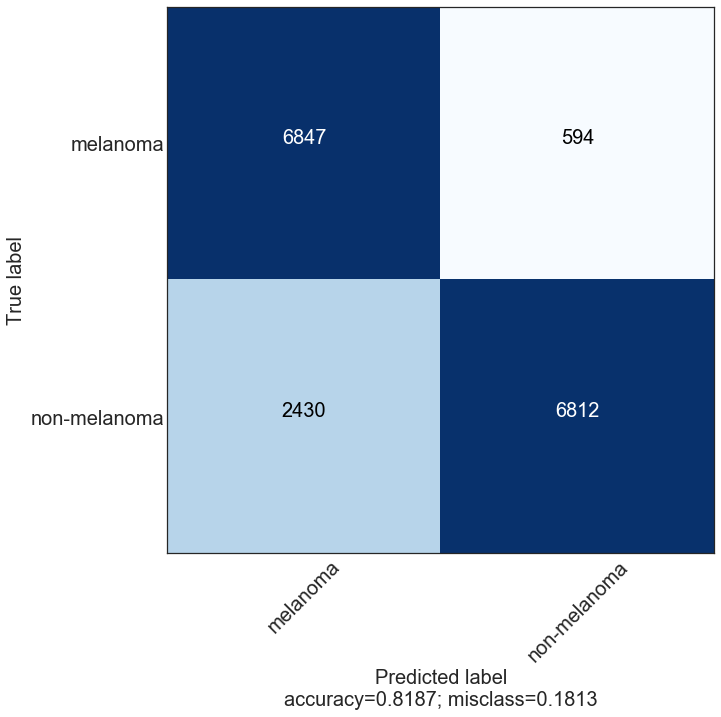

In [32]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = augmented_test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels, title=' ')